# Analyze distances

## Purpose
* The lower update rate of the AIS gives a coarser trajectory of the ship.
* How this affects the distance is examined in this notebook.

## Results
* the total sailed distance differs about 6% between SSPA AIS and GPS
* This is however disregarding missing data and that the SSPA AIS has some data reduction.
* If the 0-1 kts speeds are disregarded in the comparison, the difference is 2%.

## Setup

In [15]:
# %load imports.py
from typing import no_type_check
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyaisdb.database import DB



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
db = DB()

In [17]:
df_speed_distances = pd.DataFrame(dtype='float64')
s_gps = pd.Series(dtype='float64')
s_ais = pd.Series(dtype='float64')

## GPS data
The traveled distance can be calculated in *PostgreSQL*: 

In [18]:
for i in range(30):
    sql = f"""with blue_data as (SELECT time_info, lag(time_info, 1) OVER (ORDER by time_info ASC) as next_time, sog, 
  ST_Distance(pos::geography, lag(pos::geography, 1) OVER (ORDER by time_info ASC)) as dist
	FROM projects._49145341_d2e2f_blue_data_varmdo
	where time_info < '2020-07-19 23:59:59+02'
                  and time_info > '2020-07-10 00:00:00+02'
)
select sum(dist)/1852
from blue_data
where sog >= {i} and sog < {i + 1}"""
    # print(sql)
    distance = db.execute_and_return(sql)[0][0]
    if distance:
        #print(f'{i + 0.5} {round(result, 2)}')
        speed = i + 0.5
        s_gps[speed] = distance


## AIS data
The traveled distance can be calculated in *PostgreSQL*: 

In [19]:
for i in range(30):
    sql = f"""select sum(st_length(segment::geography)) / 1852
from segments_sjfv_2020
where sog>={i} and sog < {i+1}
and mmsi=265520390
and date2 < '2020-07-19 23:59:59+02'
and date1 > '2020-07-10 00:00:00+02' """
    distance = db.execute_and_return(sql)[0][0]
    if distance:
        #print(f'{i + 0.5} {round(result, 2)}')
        speed = i + 0.5
        s_ais[speed] = distance


In [20]:
df_speed_distances['GPS'] = s_gps
df_speed_distances['AIS'] = s_ais
df_speed_distances.index.name='speed'
df_speed_distances.head()

,GPS,AIS
speed,,
0.5,57.459776,2.785933
1.5,4.544416,3.283193
2.5,5.931864,5.042496
3.5,8.331472,9.270586
4.5,10.184976,8.352712


In [21]:
df_speed_distances.describe()

,GPS,AIS
count,23.000000,23.000000
mean,50.706558,47.447936
std,55.136500,56.258720
min,0.435807,0.516776
25%,12.320331,9.380322
50%,33.429894,29.392913
75%,60.246574,58.234950
max,201.025973,211.230779


The traveled distance in nautical miles (NM) calculated from the GPS and AIS data is as follows:

In [22]:
df_speed_distances.sum()

GPS    1166.250824
AIS    1091.302529
dtype: float64

The distance of from the AIS is about 6% shorter:

In [23]:
df_speed_distances.sum().pct_change()

GPS         NaN
AIS   -0.064264
dtype: float64

A histogram showing how the distances are distributed over various ship speeds is shown below.

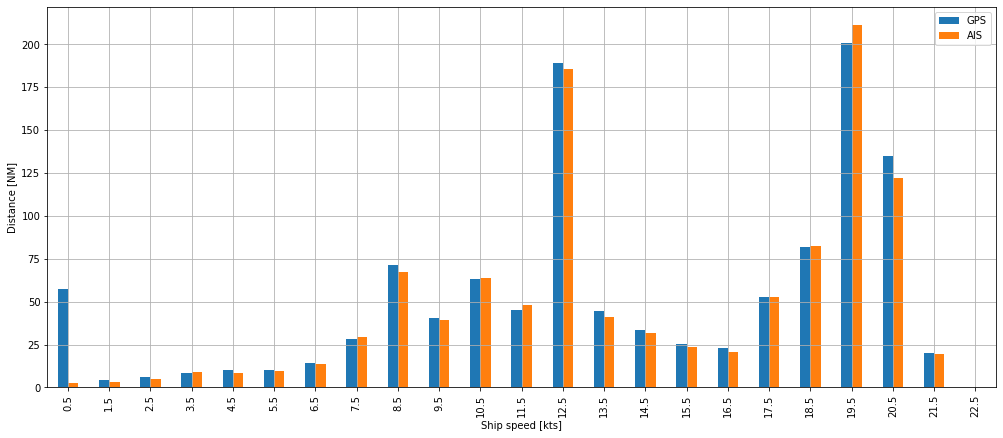

In [28]:
fig,ax=plt.subplots()
fig.set_size_inches(17,7)
df_speed_distances.plot(style='.-',ax=ax, kind='bar');
ax.grid(True)
ax.set_ylabel('Distance [NM]')
ax.set_xlabel('Ship speed [kts]');


It can be seen from this histogram that the distance differes a lot for the lowest speeds (0-1 kts). If these speeds are removed from the comparison the distance difference is reduced to about 2%, as seen below.

In [27]:
df_speed_distances.iloc[1:].sum().pct_change()

GPS         NaN
AIS   -0.018285
dtype: float64

In [25]:
df_speed_time = df_speed_distances.div(df_speed_distances.index, axis=0)

Text(0.5, 0, 'Ship speed [kts]')

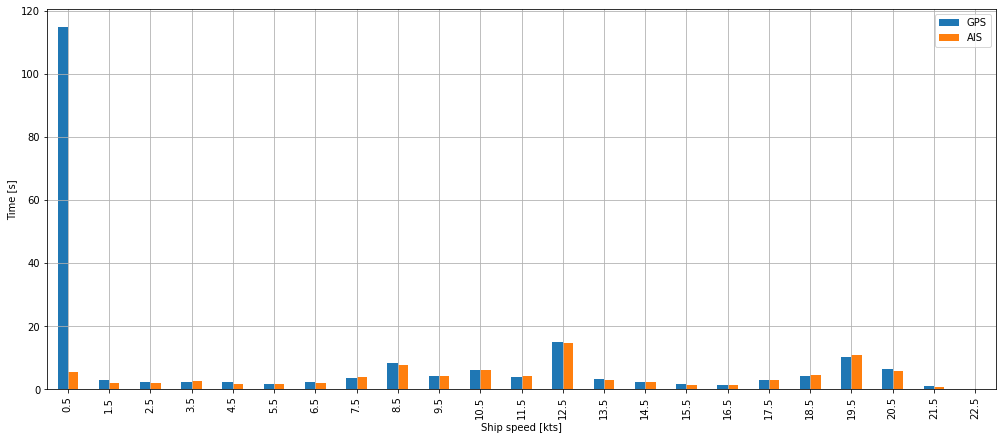

In [26]:
fig,ax=plt.subplots()
fig.set_size_inches(17,7)
df_speed_time.plot(style='.-',ax=ax, kind='bar');
ax.grid(True)
ax.set_ylabel('Time [s]')
ax.set_xlabel('Ship speed [kts]')